# Helpful functions for Tensorflow (little gem)



In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


    #Modified to_xy to get 1D y
def to_xy_1d(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


In [ ]:
import os
import pandas as pd


p1data = pd.read_csv("/content/sample_data/project1data.csv",na_values=['NA','?','-'])
p1data.head(10)

,AGE,SEX,BMI,OPEN_LAP,DM,TUMOR.SIZE,AFP,RAS,WBC,HB,...,CR,ALB,AST,ALT,GLU,CHOLESTEROL,CRYSTALLOID,PRBC,DURATION.OF.SURG,KDIGO
0,64,0,23.3,0,0,1.200000,193.0,0,4.1,12.9,...,0.70,3.7,36,35,128,197,1800,0,214,0
1,57,1,28.9,0,0,1.500000,6.1,0,5.2,14.1,...,1.00,4.0,25,24,111,125,500,0,240,0
2,45,1,29.7,0,0,1.700000,1120.0,0,4.5,16.4,...,0.90,4.6,30,29,91,146,3100,0,287,1
3,57,1,23.8,0,0,6.600000,16.0,0,5.9,11.1,...,0.52,3.0,52,48,138,93,1250,0,260,0
4,51,1,23.6,0,1,1.007298,68.7,0,5.0,15.1,...,0.90,3.9,29,34,238,199,1800,0,186,0
5,60,1,30.4,0,0,6.700000,2.3,0,4.5,14.6,...,0.89,4.2,20,16,94,128,2300,0,320,0
6,70,1,22.2,0,0,2.000000,347.0,0,7.4,14.0,...,0.69,3.8,23,50,93,182,1800,0,193,0
7,62,1,27.9,0,0,2.800000,5.3,1,4.7,14.7,...,0.68,3.6,24,43,95,128,2250,0,291,1
8,40,1,24.9,0,0,4.000000,15.3,0,3.6,13.7,...,0.81,3.4,68,88,101,139,1450,0,199,0
9,70,0,33.4,0,0,2.500000,19.0,0,3.3,11.7,...,0.60,3.4,51,52,100,141,2350,0,295,0


Check for any null data

In [ ]:
p1data[p1data.isnull().any(axis=1)]

,AGE,SEX,BMI,OPEN_LAP,DM,TUMOR.SIZE,AFP,RAS,WBC,HB,...,CR,ALB,AST,ALT,GLU,CHOLESTEROL,CRYSTALLOID,PRBC,DURATION.OF.SURG,KDIGO


Adding weights to the data set or normalizing the columns in the data set

In [ ]:

encode_numeric_zscore(p1data, 'BMI')
encode_numeric_zscore(p1data, 'TUMOR.SIZE')
encode_numeric_zscore(p1data, 'AFP')
encode_numeric_zscore(p1data, 'WBC')
encode_numeric_zscore(p1data, 'HB')
encode_numeric_zscore(p1data, 'PLT')
encode_numeric_zscore(p1data, 'CR')
encode_numeric_zscore(p1data, 'ALB')
encode_numeric_zscore(p1data, 'AST')
encode_numeric_zscore(p1data, 'ALT')
encode_numeric_zscore(p1data, 'GLU')
encode_numeric_zscore(p1data, 'CHOLESTEROL')
encode_numeric_zscore(p1data, 'CRYSTALLOID')
encode_numeric_zscore(p1data, 'DURATION.OF.SURG')

p1data

,AGE,SEX,BMI,OPEN_LAP,DM,TUMOR.SIZE,AFP,RAS,WBC,HB,...,CR,ALB,AST,ALT,GLU,CHOLESTEROL,CRYSTALLOID,PRBC,DURATION.OF.SURG,KDIGO
0,64,0,-0.325363,0,0,-0.894353,-0.149907,0,-0.743320,-0.653869,...,-0.742450,-0.254106,-0.123957,-0.073318,0.202328,0.951455,-0.471385,0,-0.702916,0
1,57,1,1.637571,0,0,-0.814569,-0.152852,0,-0.123302,0.101041,...,1.001663,0.473477,-0.483055,-0.464557,-0.158003,-1.091513,-1.793512,0,-0.382575,0
2,45,1,1.917990,0,0,-0.761380,-0.135299,0,-0.517859,1.547951,...,0.420292,1.928642,-0.319829,-0.286721,-0.581922,-0.495648,0.850743,0,0.196503,1
3,57,1,-0.150101,0,0,0.541758,-0.152696,0,0.271255,-1.786234,...,-1.788918,-1.951799,0.398366,0.389056,0.414288,-1.999499,-1.030746,0,-0.136159,0
4,51,1,-0.220205,0,1,-0.945602,-0.151865,0,-0.236032,0.730132,...,0.420292,0.230949,-0.352474,-0.108885,2.533884,1.008204,-0.471385,0,-1.047898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,44,1,0.270528,1,0,-0.628407,-0.152934,0,-0.292398,0.226859,...,0.071470,0.230949,-0.646281,-0.820230,-0.475942,-1.091513,-0.064576,0,-0.308650,0
1169,57,1,-0.255258,1,0,-0.601812,-0.152893,0,0.271255,0.604314,...,-0.800587,-0.254106,-0.287183,0.104519,0.499072,-0.353775,-1.539257,0,-0.887728,0
1170,49,1,-0.991358,1,0,-0.734785,-0.152902,0,0.778542,0.415586,...,1.176075,2.413697,-0.678926,-0.926931,-0.497138,-0.637520,-0.878193,0,-1.355918,0
1171,43,1,0.831366,1,0,0.231737,0.927240,0,0.891272,1.296315,...,0.420292,0.230949,-0.678926,-0.713528,-0.581922,0.100218,-1.285002,0,-1.318956,0


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
x,y = to_xy_1d(p1data,"KDIGO")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x_oversample, y_oversample = pipeline.fit_resample(x_train, y_train)

In [ ]:
x

array([[64.        ,  0.        , -0.32536256, ..., -0.4713846 ,
         0.        , -0.7029158 ],
       [57.        ,  1.        ,  1.6375706 , ..., -1.7935123 ,
         0.        , -0.38257498],
       [45.        ,  1.        ,  1.9179896 , ...,  0.8507431 ,
         0.        ,  0.19650257],
       ...,
       [49.        ,  1.        , -0.99135774, ..., -0.87819314,
         0.        , -1.355918  ],
       [43.        ,  1.        ,  0.8313659 , ..., -1.2850016 ,
         0.        , -1.3189557 ],
       [42.        ,  1.        , -1.3769339 , ..., -0.8273421 ,
         0.        , -1.3682389 ]], dtype=float32)

# **Logistic Regression Model**



Logistic Regression model without over sampling

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logisticregressionfit = LogisticRegression(solver='lbfgs', max_iter=1000,class_weight = 'balanced', multi_class='ovr')

# fit the model with data
logisticregressionfit.fit(x_train,y_train)

y_logistic_pred=logisticregressionfit.predict(x_test)

[[149  66]
 [  9  11]]

Plotting confusion matrix


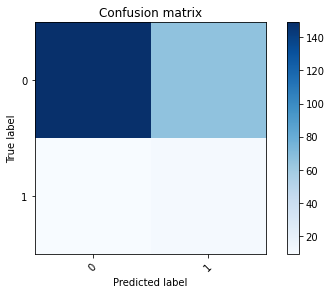

NameError: ignored

In [ ]:
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for Logistic regression
cm = confusion_matrix(y_test, y_logistic_pred)
print(cm)

print()
kdigoop = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, kdigoop)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, y_logistic_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_logistic_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_logistic_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_logistic_pred,target_names=target_names))

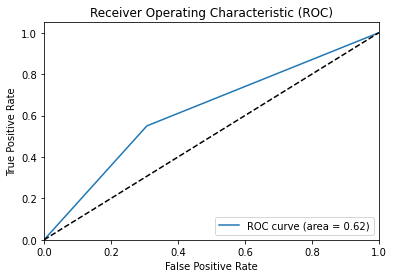

In [ ]:
plot_roc(y_logistic_pred,y_test)


Logistic Regression with over sampled data

In [ ]:
from numpy import mean
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# instantiate the model (using the default parameters)
logisticregressionfit = LogisticRegression(solver='lbfgs', max_iter=400,class_weight = 'balanced', multi_class='ovr')

# fit the model with data
logisticregressionfit.fit(x_oversample,y_oversample)
Y_logistic_sampled_pred=logisticregressionfit.predict(x_test)


[[143  72]
 [  8  12]]

Plotting confusion matrix


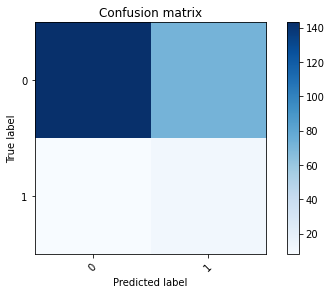


Precision score : 0.14285714285714285
Recall score    : 0.6
F1 score        : 0.23076923076923073

              precision    recall  f1-score   support

         AKI       0.95      0.67      0.78       215
      NO AKI       0.14      0.60      0.23        20

    accuracy                           0.66       235
   macro avg       0.54      0.63      0.51       235
weighted avg       0.88      0.66      0.73       235



In [ ]:
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for Logistic regression
cm = confusion_matrix(y_test, Y_logistic_sampled_pred)
print(cm)

print()
kdigoop = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, kdigoop)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, Y_logistic_sampled_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, Y_logistic_sampled_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, Y_logistic_sampled_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, Y_logistic_sampled_pred,target_names=target_names))

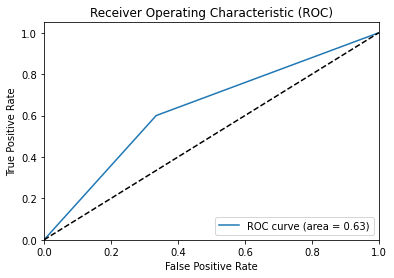

In [ ]:
plot_roc(Y_logistic_sampled_pred,y_test)

# **Nearest Neighbor**

Knn model without over sampling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support

knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=3, p=1)
knn.fit(x_train, y_train)
yknn_pred=knn.predict(x_test)
precision_recall_fscore_support(y_test, yknn_pred, average='weighted')[2]

0.8699658054711246

[[213   2]
 [ 20   0]]

Plotting confusion matrix


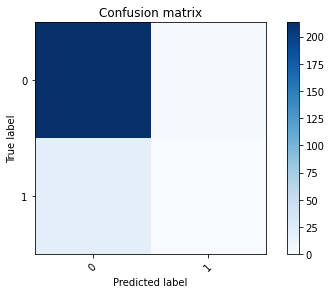


Precision score : 0.0
Recall score    : 0.0
F1 score        : 0.0

              precision    recall  f1-score   support

         AKI       0.91      0.99      0.95       215
      NO AKI       0.00      0.00      0.00        20

    accuracy                           0.91       235
   macro avg       0.46      0.50      0.48       235
weighted avg       0.84      0.91      0.87       235



In [ ]:
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for KNN
cm = confusion_matrix(y_test, yknn_pred)
print(cm)

print()
label = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, yknn_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, yknn_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, yknn_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, yknn_pred,target_names=target_names))

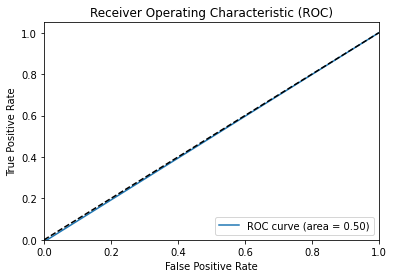

In [ ]:
plot_roc(yknn_pred,y_test)

KNN with the over sampling data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support

knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=3, p=1)
knn.fit(x_oversample, y_oversample)
yknn_pred_sample=knn.predict(x_test)
precision_recall_fscore_support(y_test, yknn_pred, average='weighted')[2]

0.8699658054711246

[[169  46]
 [ 11   9]]

Plotting confusion matrix


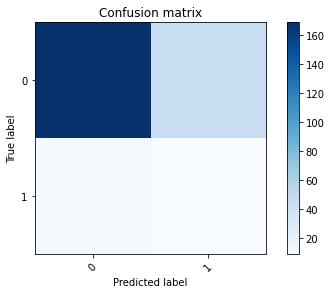


Precision score : 0.16363636363636364
Recall score    : 0.45
F1 score        : 0.24

              precision    recall  f1-score   support

         AKI       0.94      0.79      0.86       215
      NO AKI       0.16      0.45      0.24        20

    accuracy                           0.76       235
   macro avg       0.55      0.62      0.55       235
weighted avg       0.87      0.76      0.80       235



In [ ]:
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for Fully connected Nueral Network model
cm = confusion_matrix(y_test, yknn_pred_sample)
print(cm)

print()
label = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, yknn_pred_sample)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, yknn_pred_sample)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, yknn_pred_sample)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, yknn_pred_sample,target_names=target_names))

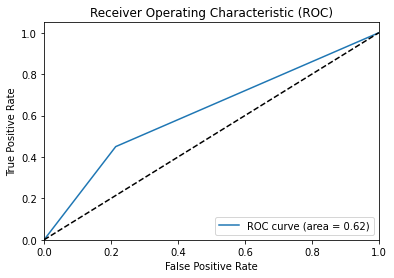

In [ ]:
plot_roc(yknn_pred_sample,y_test)

# **Support Vector Machine**

SVM Linear Model without over sampling

In [ ]:
#Import svm model
from sklearn import svm

clf = svm.SVC(kernel='linear',max_iter=100, degree=2, probability=True) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[ 76 139]
 [  8  12]]


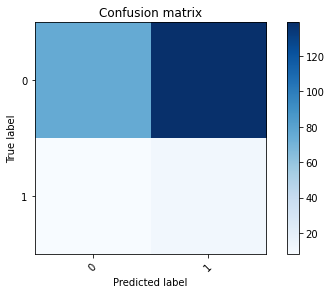


Precision score : 0.07947019867549669
Recall score    : 0.6
F1 score        : 0.14035087719298248

              precision    recall  f1-score   support

         AKI       0.90      0.35      0.51       215
      NO AKI       0.08      0.60      0.14        20

    accuracy                           0.37       235
   macro avg       0.49      0.48      0.32       235
weighted avg       0.83      0.37      0.48       235



In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM linear model
cm = confusion_matrix(y_test, y_pred)
print(cm)


plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred,target_names=target_names))

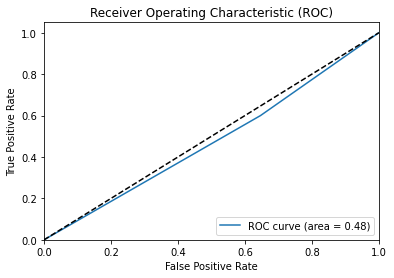

In [ ]:
plot_roc(y_pred,y_test)

SVM linear over sampled data

In [ ]:

svm_sampled = svm.SVC(kernel='linear',max_iter=100, degree=2, probability=True) # Linear Kernel

#Train the model using the training sets
svm_sampled.fit(x_oversample, y_oversample)

#Predict the response for test dataset
y_pred_svmln = svm_sampled.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[118  97]
 [ 10  10]]


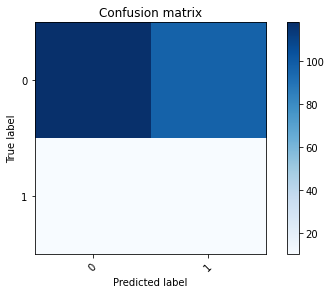


Precision score : 0.09345794392523364
Recall score    : 0.5
F1 score        : 0.15748031496062992

              precision    recall  f1-score   support

         AKI       0.92      0.55      0.69       215
      NO AKI       0.09      0.50      0.16        20

    accuracy                           0.54       235
   macro avg       0.51      0.52      0.42       235
weighted avg       0.85      0.54      0.64       235



In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM linear model
cm = confusion_matrix(y_test, y_pred_svmln)
print(cm)


plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred_svmln)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred_svmln)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred_svmln)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred_svmln,target_names=target_names))

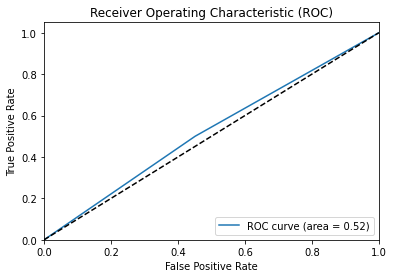

In [ ]:

plot_roc(y_pred_svmln,y_test)

SVM Polynomial Model without over sampling

In [ ]:
clf1 = svm.SVC(kernel='poly',max_iter=70, degree=2, probability=True) # Linear Kernel

#Train the model using the training sets
clf1.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf1.predict(x_test)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[215   0]
 [ 20   0]]


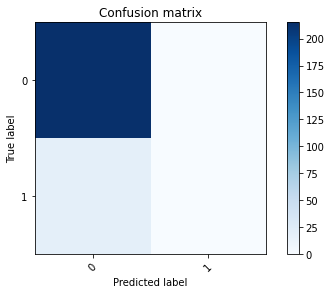


Precision score : 0.0
Recall score    : 0.0
F1 score        : 0.0

              precision    recall  f1-score   support

         AKI       0.91      1.00      0.96       215
      NO AKI       0.00      0.00      0.00        20

    accuracy                           0.91       235
   macro avg       0.46      0.50      0.48       235
weighted avg       0.84      0.91      0.87       235



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM polynomial
cm = confusion_matrix(y_test, y_pred)
print(cm)


plt.figure()
plot_confusion_matrix(cm, label)
plt.show()


print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred,target_names=target_names))


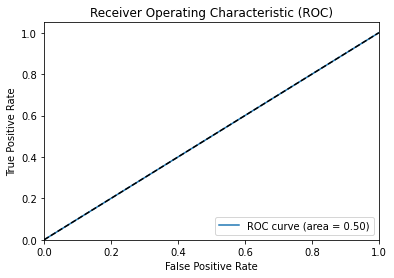

In [ ]:
plot_roc(y_pred,y_test)

SVM polynomial over sampled data

In [ ]:
svm_sampled = svm.SVC(kernel='poly',max_iter=70, degree=2, probability=True) # Linear Kernel

#Train the model using the training sets
svm_sampled.fit(x_oversample, y_oversample)

#Predict the response for test dataset
y_pred_svmpy = svm_sampled.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=70).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[125  90]
 [  7  13]]


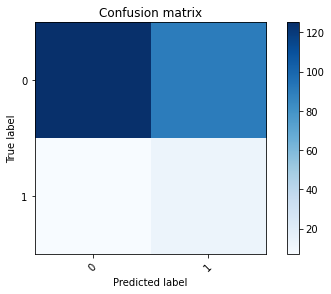


Precision score : 0.1262135922330097
Recall score    : 0.65
F1 score        : 0.2113821138211382

              precision    recall  f1-score   support

         AKI       0.95      0.58      0.72       215
      NO AKI       0.13      0.65      0.21        20

    accuracy                           0.59       235
   macro avg       0.54      0.62      0.47       235
weighted avg       0.88      0.59      0.68       235



In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM polynomial
cm = confusion_matrix(y_test, y_pred_svmpy)
print(cm)


plt.figure()
plot_confusion_matrix(cm, label)
plt.show()


print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred_svmpy)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred_svmpy)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred_svmpy)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred_svmpy,target_names=target_names))


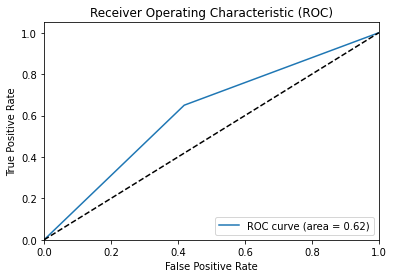

In [ ]:
plot_roc(y_pred_svmpy,y_test)

SVM rbf model without over sampling

In [ ]:
clf2 = svm.SVC(kernel='rbf',max_iter=86, degree=1, probability=True)

#Train the model using the training sets
clf2.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf2.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=86).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[215   0]
 [ 20   0]]
Plotting confusion matrix


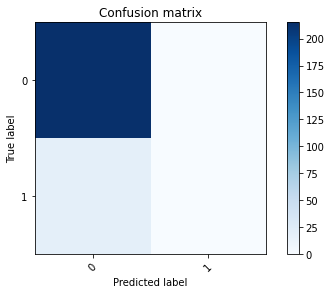


Precision score : 0.0
Recall score    : 0.0
F1 score        : 0.0

              precision    recall  f1-score   support

         AKI       0.91      1.00      0.96       215
      NO AKI       0.00      0.00      0.00        20

    accuracy                           0.91       235
   macro avg       0.46      0.50      0.48       235
weighted avg       0.84      0.91      0.87       235



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM rblf
cm = confusion_matrix(y_test, y_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred,target_names=target_names))


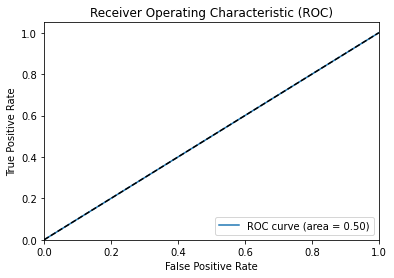

In [ ]:
plot_roc(y_pred,y_test)

SVM RBF model with the over sampled data

In [ ]:
svm_sampled = svm.SVC(kernel='rbf',max_iter=86, degree=1, probability=True)  # Linear Kernel

#Train the model using the training sets
svm_sampled.fit(x_oversample, y_oversample)

#Predict the response for test dataset
y_pred_svmrbf = svm_sampled.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=86).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[133  82]
 [  8  12]]


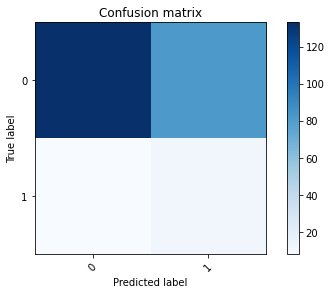


Precision score : 0.1276595744680851
Recall score    : 0.6
F1 score        : 0.21052631578947367

              precision    recall  f1-score   support

         AKI       0.94      0.62      0.75       215
      NO AKI       0.13      0.60      0.21        20

    accuracy                           0.62       235
   macro avg       0.54      0.61      0.48       235
weighted avg       0.87      0.62      0.70       235



In [ ]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for SVM rbf model
cm = confusion_matrix(y_test, y_pred_svmrbf)
print(cm)


plt.figure()
plot_confusion_matrix(cm, label)
plt.show()


print()

#Precision
pr_score = metrics.precision_score(y_test, y_pred_svmrbf)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_test, y_pred_svmrbf)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_test, y_pred_svmrbf)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_test, y_pred_svmrbf,target_names=target_names))


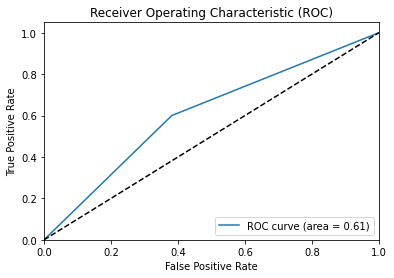

In [ ]:
plot_roc(y_pred_svmrbf,y_test)

# **Fully-Connected Neural Networks**

Fully Connected Neural Network without over sampling

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [ ]:
x,y = to_xy(p1data,"KDIGO")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.32, random_state=42)


In [ ]:
#activation function as tanh optimizer as sgd
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath=r"/content/sample_data/bst_weights_f_1.hdf5", verbose=2, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(5, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.49102, saving model to /content/sample_data/bst_weights_f_1.hdf5
25/25 - 1s - loss: 0.6276 - val_loss: 0.4910 - 778ms/epoch - 31ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.49102 to 0.41517, saving model to /content/sample_data/bst_weights_f_1.hdf5
25/25 - 0s - loss: 0.4571 - val_loss: 0.4152 - 127ms/epoch - 5ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.41517 to 0.37377, saving model to /content/sample_data/bst_weights_f_1.hdf5
25/25 - 0s - loss: 0.4029 - val_loss: 0.3738 - 134ms/epoch - 5ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.37377 to 0.34675, saving model to /content/sample_data/bst_weights_f_1.hdf5
25/25 - 0s - loss: 0.3709 - val_loss: 0.3468 - 129ms/epoch - 5ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.34675 to 0.32712, saving model to /content/sample_data/bst_weights_f_1.hdf5
25/25 - 0s - loss: 0.3491 - val_loss: 0.3271 - 157ms/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss impro

In [ ]:
print('Training finished...Loading the best model')
print()
model.load_weights(r"/content/sample_data/bst_weights_f_1.hdf5")
# load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Training finished...Loading the best model

12/12 [==============================] - 0s 1ms/step
Final accuracy: 0.9414893617021277


[[354   0]
 [ 22   0]]
Plotting confusion matrix


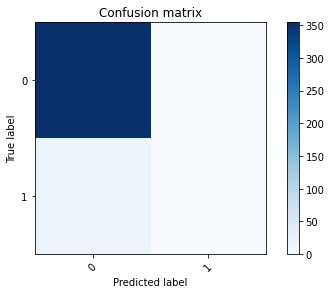


Precision score : 0.0
Recall score    : 0.0
F1 score        : 0.0

              precision    recall  f1-score   support

         AKI       0.94      1.00      0.97       354
      NO AKI       0.00      0.00      0.00        22

    accuracy                           0.94       376
   macro avg       0.47      0.50      0.48       376
weighted avg       0.89      0.94      0.91       376



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for Fully connected Nueral Network model
cm = confusion_matrix(y_true, pred)
print(cm)

label = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

print()

#Precision
pr_score = metrics.precision_score(y_true, pred)
print("Precision score : {}".format(pr_score))

#Recall
re_score = metrics.recall_score(y_true, pred)
print("Recall score    : {}".format(re_score))

#F1 Score
f1_score = metrics.f1_score(y_true, pred)
print("F1 score        : {}".format(f1_score))

print()

target_names = ['NON AKI', 'AKI']
print(classification_report(y_true, pred,target_names=target_names))

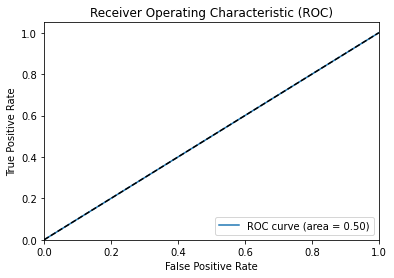

In [ ]:
#Plot ROC Curve for Fully Connected Nueral Network
plot_roc(pred,y_true)

Full connected model with over sampled data

In [ ]:
x,y = to_xy_1d(p1data,"KDIGO")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=0)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x_oversample, y_oversample = pipeline.fit_resample(x_train, y_train)

In [ ]:
checkpointer = ModelCheckpoint(filepath=r"/content/sample_data/bst_weights_f_1.hdf5", verbose=0, save_best_only=True) # save best model



for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_oversample,y_oversample,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=150)
pred = model.predict(x_test).round()

0
Epoch 1/150
8/8 - 1s - loss: 11.5959 - val_loss: 2.9462 - 1s/epoch - 167ms/step
Epoch 2/150
8/8 - 0s - loss: 10.1468 - val_loss: 2.5614 - 82ms/epoch - 10ms/step
Epoch 3/150
8/8 - 0s - loss: 8.6635 - val_loss: 2.2236 - 86ms/epoch - 11ms/step
Epoch 4/150
8/8 - 0s - loss: 7.4786 - val_loss: 1.9034 - 81ms/epoch - 10ms/step
Epoch 5/150
8/8 - 0s - loss: 6.3144 - val_loss: 1.5996 - 79ms/epoch - 10ms/step
Epoch 6/150
8/8 - 0s - loss: 5.2143 - val_loss: 1.3161 - 79ms/epoch - 10ms/step
Epoch 7/150
8/8 - 0s - loss: 4.2003 - val_loss: 1.0382 - 85ms/epoch - 11ms/step
Epoch 8/150
8/8 - 0s - loss: 3.1961 - val_loss: 0.7701 - 94ms/epoch - 12ms/step
Epoch 9/150
8/8 - 0s - loss: 2.2396 - val_loss: 0.5147 - 126ms/epoch - 16ms/step
Epoch 10/150
8/8 - 0s - loss: 1.2821 - val_loss: 0.3628 - 82ms/epoch - 10ms/step
Epoch 11/150
8/8 - 0s - loss: 0.6725 - val_loss: 0.6314 - 63ms/epoch - 8ms/step
Epoch 12/150
8/8 - 0s - loss: 0.5935 - val_loss: 0.8375 - 67ms/epoch - 8ms/step
Epoch 13/150
8/8 - 0s - loss: 0.586

[[292  28]
 [ 26   6]]
Plotting confusion matrix


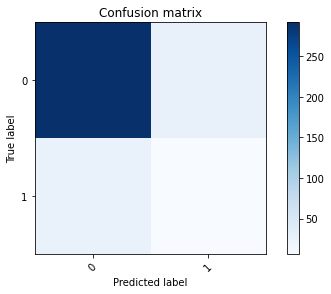

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       320
         1.0       0.18      0.19      0.18        32

    accuracy                           0.85       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.85      0.85      0.85       352



In [ ]:
import numpy as np
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix for Fully connected Nueral Network model
cm = confusion_matrix(y_test, pred)
print(cm)

label = encode_text_index(p1data,"KDIGO")
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, label)
plt.show()



print(classification_report(y_test, pred))

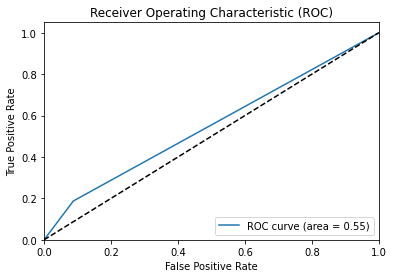

In [ ]:

plot_roc(pred,y_test)